In [71]:
import numpy as np
import pandas as pd
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import time
from astropy.coordinates import GeocentricMeanEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import GeocentricTrueEcliptic

#This function takes a parameter Dataframe in RA/DEC, and converts it to Latitude and Longitude, while also converting the dates to Primary-Centric Julian dates
def convert_to_primary_centric(paramsDF,objectName):
    columnList = list(paramsDF)
    
    #Current column names are just descriptive, not representative of final product column names
    updatedDF = pd.DataFrame(columns = ['Primary-Centric Time','Delta_lat','Delta_lon'])
    
    #Convert the dates into a Julian date format
    date = paramsDF['Dates']
    dateList = []
    for i in date:
        jd = Time(i,format='jd')
        dateList.append(jd)
        
    #Get the Horizons data for the object at the times it was observed
    primary = Horizons(id=objectName,location=None,epochs=dateList)
    
    updatedDF['Primary-Centric Time'] = paramsDF['Dates']-primary.vectors()['lighttime']
    
    
    #First, put the values in the dataframe into numpy arrays. Currently using the Grundy data for MakeMake
    deltaRA = np.array(paramsDF['Delta-RA'])
    deltaDEC = np.array(paramsDF['Delta-DEC'])
    RA_primary = np.array(paramsDF['RA-Primary'])
    DEC_primary = np.array(paramsDF['DEC-Primary'])
    RA_obj = RA_primary+deltaRA/3600
    DEC_obj = DEC_primary+deltaDEC/3600
    
    #Essentially we define where the object is in our RA/DEC coordinate system. ICRS is the system our coordinates are in.
    moonC = SkyCoord(ra=RA_obj*u.degree, dec=DEC_obj*u.degree, frame='icrs')
    primC = SkyCoord(ra=RA_primary*u.degree, dec=DEC_primary*u.degree, frame='icrs')

    #This transformation takes the defined coordinate system, and converts it to the GeocentricMeanEcliptic coordinate system.
    moonEcl = moonC.transform_to(GeocentricMeanEcliptic(equinox='J2000'))
    primEcl = primC.transform_to(GeocentricMeanEcliptic(equinox='J2000'))
    
    #These are the positions of the moon relative to the primary
    updatedDF['Latitude_moon'] = moonEcl.lat.degree
    updatedDF['Longitude_moon'] = moonEcl.lon.degree
    
    #These are the positions of the primary
    updatedDF['Latitude_prim'] = primEcl.lat.degree
    updatedDF['Longitude_prim'] = primEcl.lon.degree
    
    #These are the positions of the moon relative to the primary using Grundy's Delta-lat and Delta-lon
    updatedDF['OgLat_moon']=np.array(updatedDF['Latitude_prim'])+np.array(paramsDF['Delta_lat'])/3600
    updatedDF['OgLon_moon']= np.array(updatedDF['Longitude_prim'])+np.array(paramsDF['Delta_lon'])/3600
    
    #Calculated Delta-lat and Delta lon from the RA and DEC's
    updatedDF['Delta_lat'] = (updatedDF['Latitude_prim']-updatedDF['Latitude_moon'])*3600
    updatedDF['Delta_lon'] = (updatedDF['Longitude_prim']-updatedDF['Longitude_moon'])*3600
    
    #We are just going to plot one iteration of the data
    lats = [updatedDF['Latitude_moon'][1],updatedDF['Latitude_prim'][1],updatedDF['OgLat_moon'][1]]
    longs = [updatedDF['Longitude_moon'][1],updatedDF['Longitude_prim'][1],updatedDF['OgLon_moon'][1]]
    lats = [i*3600 for i in lats]
    longs = [i*3600 for i in longs]
 
    #Plot the primary, and the moon's position based on calulcation. Also plot the moon based on the origianl data's delta-lat and delta-lon
    plt.scatter(lats,longs)
    plt.axes().set_aspect('equal')
    plt.show()

    fileName = 'New'+objectName+'_LatLon.csv'
    updatedDF.to_csv(fileName,sep='\t')


C:\Users\annas\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


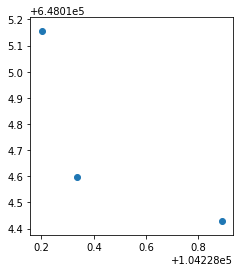

In [72]:
paramsDF = pd.read_csv('GrundyData1.csv')

convert_to_primary_centric(paramsDF,'MakeMake')


In [24]:
def ratodeg(hours, minutes, seconds):
	degrees = 0
	degrees += hours*15.0
	degrees += minutes*0.25
	degrees += seconds*0.004166666667
	return degrees

def dectodeg(degree,minutes,seconds):
	degrees = 0
	degrees += degree
	degrees += minutes/60
	degrees += seconds/3600
	return degrees

print(ratodeg(12,49,39.242))
print(dectodeg(26,22,10.14))

192.4135083333464
26.369483333333335
